# Dissipation VS Current Fluctuations

We are trying to apply the idea presented by Barato and Seifert (PRL, 2015) and proved by Gingrich et al. (PRL, 2016) to motility assays.
The data is a set of microtubule positions extracted by O. Idan and M. Armstrong for Palacci et al. (Langmuir, 2016). The pre-processing was done previously using XL, and the resulting file has a set of microtubule displacements measured in μm every 2 seconds, for 20 microtubules and 5 different kinesin densities.

We need to do the following:
- estimate the number of bound kinesins to each microtubule using the width found previously
- estimate the fluctuations for various t
- estimate the amount of dissipation, using average ATP consumption - we can initially neglect the hydrodynamic dissipation
- do this for varying Δt and plot the product of the dissipation and the fluctuation; then see what happens

In [1]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(magrittr)
library(tidyr)
library(broom)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



## First data scrub

In [2]:
motility_data <- read.csv("../data/fluctdata.csv")
head(motility_data)

,mt_id,x,y,density,mt,t_seconds,mt_length,deltaR_um
1,1_250,832,182,250,1,2,5.9734,0
2,1_250,830.833,188.25,250,1,4,5.9734,1.271604
3,1_250,827.25,191,250,1,6,5.9734,0.9033358
4,1_250,826.375,197.625,250,1,8,5.9734,1.336507
5,1_250,823,203,250,1,10,5.9734,1.26935
6,1_250,822.042,206.917,250,1,12,5.9734,0.80649


In [3]:
# ugly replacing of approximate density factors with their values
# the density of kinesin on the surface is given in 1/um2
densities <- motility_data$density
densities[densities == 250] <- 310
densities[densities == 500] <- 620
densities[densities == 1000] <- 1250
densities[densities == 2000] <- 2500
densities[densities == 2500] <- 3100
motility_data$density <- densities

In [6]:
# we define the effective width of binding of each MT according to Palacci et al.
effective_width <- 0.088 # 88 nm defined in um

# we add the estimated number of bound kinesin to the data frame
motility_data %<>% mutate(n_kinesin = mt_length * effective_width * density)

# we then add the estimated number of kTs dissipated per period

atp_energy = 20 # our energy unit will be kTs
hydro_rate = 100 # kinesin hydrolyses 100 ATP per second

motility_data %<>% mutate(dissipation = n_kinesin * atp_energy * hydro_rate * 2)


In [7]:
head(motility_data)

,mt_id,x,y,density,mt,t_seconds,mt_length,deltaR_um,n_kinesin,dissipation
1,1_250,832,182,310,1,2,5.9734,0,162.9544,651817.4
2,1_250,830.833,188.25,310,1,4,5.9734,1.271604,162.9544,651817.4
3,1_250,827.25,191,310,1,6,5.9734,0.9033358,162.9544,651817.4
4,1_250,826.375,197.625,310,1,8,5.9734,1.336507,162.9544,651817.4
5,1_250,823,203,310,1,10,5.9734,1.26935,162.9544,651817.4
6,1_250,822.042,206.917,310,1,12,5.9734,0.80649,162.9544,651817.4


In [10]:
# now regrouping data to calculate the relative error and plot

diss_vs_fluc <- motility_data %>% group_by(mt_id) %>% summarise(avg_diss = mean(dissipation), 
                                                fluct = var(deltaR_um)/mean(deltaR_um)^2)

Warning message:
: Removed 1 rows containing missing values (geom_point).

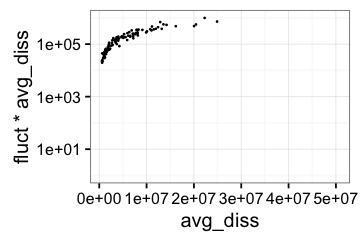

In [27]:
# and plotting our uncertainty relationship:
options(repr.plot.width = 3, repr.plot.height = 2)

plot1 <- ggplot(data = diss_vs_fluc, aes(x=avg_diss,y = fluct * avg_diss)) + geom_point(size=0.1) + 
    theme_bw() +
    scale_y_log10(limits = c(1,1000000))
print(plot1)